# Build Your Own HPSS

In this section, we will demonstrate the basics of extending `nussl`.
Later in the tutorial, we will see how the `nussl` API can help us
build advanced neural network architectures. For now, we'll learn
about the API and a new source separation algorithm:



In [1]:
%%capture
!pip install git+https://github.com/source-separation/tutorial

In [2]:
# Do our imports
import warnings
warnings.simplefilter('ignore')
import nussl
import matplotlib.pyplot as plt
import numpy as np
import librosa
from common import viz

## Harmonic-Percussive Source Separation (HPSS)

If you spend enough time visualizing musical signals on a spectrogram, you start to notice that harmonic sounds look similar horizontal stripes on a spectrogram and percussive sounds look similar to vertical stripes. Let's have a look at the audio example from the previous notebook again:

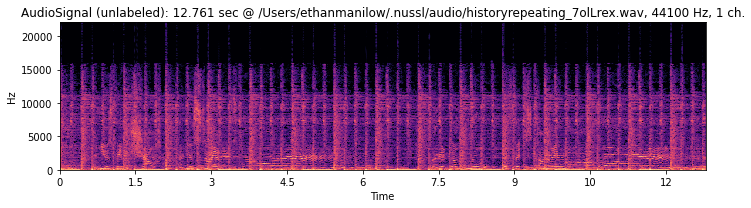

In [3]:
audio_path = nussl.efz_utils.download_audio_file('historyrepeating_7olLrex.wav', verbose=False)
history = nussl.AudioSignal(audio_path)
history.embed_audio()

plt.figure(figsize=(10, 3))
nussl.utils.visualize_spectrogram(history)
plt.title(str(history))
plt.tight_layout()
plt.show()

The insight of Harmonic-Percussive Source Separation (HPSS) is that we can apply median filter accross frequency bins (horizontal, or harmonic) and across time bins (vertical, or percussive) to separate sources.

Let's build our own HPSS algorithm using `nussl`.


## `nussl`'s Separation API

`nussl` has a class-based API for adding new algorithms. All separation algorithms
in `nussl` inherit from `SeparationBase`. `SeparationBase` has a child class called
`MaskSeparationBase`, which takes care of applying a mask if we create one. Let's
make our HPSS class inherit from `MaskSeparationBase`.


Then there are only two methods we need to overwrite:

  1. `__init__(self, audio_signal)` which accepts an `AudioSignal` and does
     setup.
  2. `run(self)` which runs our HPSS separation on `audio_signal` that we got in the init.
     It returns a list of masks, each one as a `nussl.MaskBase()` object. We can turn a `numpy` array
     into `MaskBase()` by calling `mask = self.mask_type(mask)` and `nussl` will 
     automatically set the mask type correctly.
     
The only other thing we'll need is the size of the median filter's kernel. We
can set that as a parameter that the user can set in the init.


In [5]:
class MyHPSS(nussl.separation.base.MaskSeparationBase):
    
    def __init__(self, audio_signal, kernel_size=31, mask_type='soft',
                 mask_threshold=0.5):
        """Setup code goes here."""
        
        # The super class will save all of these attributes for us.
        super().__init__(
            input_audio_signal=audio_signal, 
            mask_type=mask_type,
            mask_threshold=mask_threshold
        )
        
        # Save the kernel size.
        self.kernel_size = kernel_size
        
    def run(self):
        """Code for running HPSS. Returns masks."""
        
        # Keep a list of each mask type.
        harmonic_masks = []
        percussive_masks = []

        # Our signal might have more than one channel:
        # Apply HPSS to each channel individually.
        for ch in range(self.audio_signal.num_channels):
            # apply mask
            harmonic_mask, percussive_mask = librosa.decompose.hpss(
                self.stft[:, :, ch], kernel_size=self.kernel_size, mask=True)
            harmonic_masks.append(harmonic_mask)
            percussive_masks.append(percussive_mask)

        # Order the masks correctly.
        harmonic_masks = np.stack(harmonic_masks, axis=-1)
        percussive_masks = np.stack(percussive_masks, axis=-1)
        _masks = np.stack([harmonic_masks, percussive_masks], axis=-1)
        
        # Convert the masks to `nussl.MaskBase` types.
        self.result_masks = []
        for i in range(_masks.shape[-1]):
            mask_data = _masks[..., i]
            if self.mask_type == self.MASKS['binary']:
                mask_data = _masks[..., i] == np.max(_masks, axis=-1)
            mask = self.mask_type(mask_data)
            self.result_masks.append(mask)

        # Return the masks>
        return self.result_masks
        

## Using Our HPSS Algorithm

Awesome! Now let's run our HPSS on the audio example above:

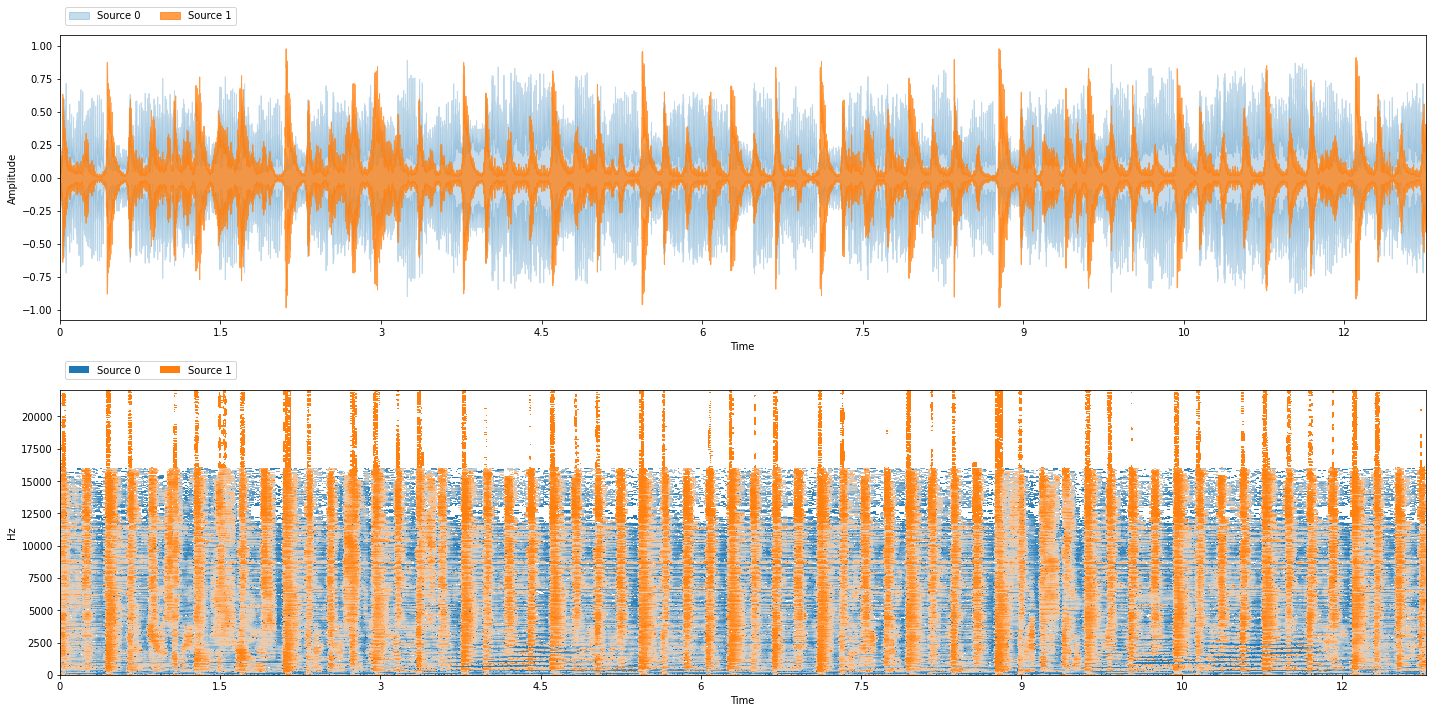


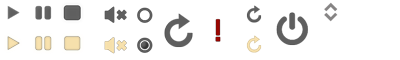
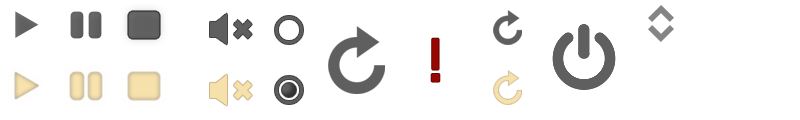
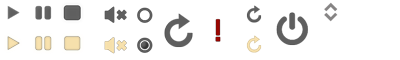

In [6]:
my_hpss = MyHPSS(history)
hpss_estimates = my_hpss()

viz.show_sources(hpss_estimates)

And, as always, we can make an interactive version of this. Try recording yourself whistling and clapping
at the same time and see how the results sound!

In [7]:
%%capture
# Comment out the line above to run this cell
# interactively in Colab or Jupyter Notebook

my_hpss.interact(share=True, source='microphone')

ImportError: To use this functionality, you must install gradio: pip install gradio.

If you want to upload a song, you can also remove `source='microphone'` in the `interact()` call:

In [1]:
%%capture
# Comment out the line above to run this cell
# interactively in Colab or Jupyter Notebook

my_hpss.interact(share=True)

NameError: name 'my_hpss' is not defined

That's it! The `nussl` API is quite simple; what goes on _inside_ of it is
the hard part!

Towards the end of this tutorial you will learn how to use the `nussl` API
to train and run advanced neural networks for source separation.